## Training a NN using differents methods
### Author: Leonardo Bravo

## Abstract
In this notebook, it trains a Bayesian NN using pytorch. And it compares differents methods for training it. It trys 3 different methods: conventional ELBO, Alpha divergence and SVGD. It compare obtained results and arguments possible differences between methods.

# Loading libraries

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
from tqdm.notebook import tqdm

# Bayesian Neural Network using recent algorithms for VI

Consider the following synthetic data for classification

<IPython.core.display.Javascript object>


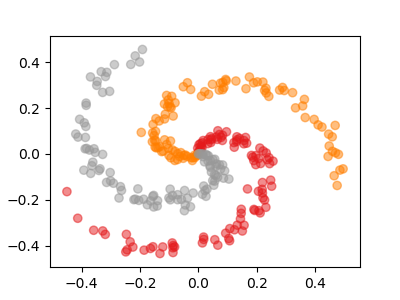

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='int') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0, 0.5, N) # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

#X, y = sklearn.datasets.make_moons(200, noise=0.2)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, alpha=0.5);

## Passing data format to numpy

In [3]:
x_train = torch.from_numpy(X.astype('float32'))
y_train = torch.from_numpy(y)

# Activities

- Implement a bayesian neural network (BNN) model using Pyro
- Train the model using the conventional ELBO objective
- Obtain and visualize the predictive posterior in data space
- Compare with the [$\alpha$ divergence objective](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.renyi_elbo.RenyiELBO), explore the influence of $\alpha$ in the results
- Compare with the [SVGD estimator](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.svgd.SVGD) with RBF kernel, explore the influence of the kernel parameters 

## Implement a bayesian neural network (BNN) model using Pyro

It implements a very basic NN using 1 hidden layer.

In [4]:
from pyro.nn import PyroSample, PyroModule
from pyro.distributions import Normal, Categorical

class leo_bayesian(PyroModule):
    
    def __init__(self, num_hidden = 10, prior_std = 1.):
        
        # call to father constructor
        super().__init__()
        
        # define prior
        prior = Normal(0, prior_std)
        
        # Define layers
        
        # linear layer 1
        self.linear_layer = PyroModule[torch.nn.Linear](2, num_hidden)
        
        # linear alyer parameters as random variables
        self.linear_layer.weights = PyroSample(prior.expand([num_hidden, 2]).to_event(2))
        self.linear_layer.bias = PyroSample(prior.expand([num_hidden]).to_event(1))
        
        # linear layer 2
        # output dimension is 3 because of the number of classes
        self.output_layer = PyroModule[torch.nn.Linear](num_hidden, 3)
        
        # linear alyer parameters as random variables
        self.output_layer.weights = PyroSample(prior.expand([3, num_hidden]).to_event(2))
        self.output_layer.bias = PyroSample(prior.expand([3]).to_event(1))
        
        # activation function
        self.activation = torch.nn.Tanh()
        
    def forward(self, x, y = None):
            
        # latent variable
        z = self.activation(self.linear_layer(x))
        
        z = self.output_layer(z).squeeze(1)
        
        # likelihood
        with pyro.plate("data",size = x.shape[0], dim = -1):
#         with pyro.plate("data",size = x.shape[0], dim = -2):
            
            # z is the input to the distribution (categorical)
            obs = pyro.sample("obs", Categorical(logits = z), obs=y)
            
        # return latent variable
        return z

It validates the archiquecture of the NN

In [5]:
# validate NN

pyro.enable_validation(True)

model = leo_bayesian()

print(pyro.poutine.trace(model).get_trace(x_train, y_train).format_shapes())

         Trace Shapes:          
          Param Sites:          
   linear_layer.weight  10  2   
   output_layer.weight   3 10   
         Sample Sites:          
linear_layer.bias dist      | 10
                 value      | 10
output_layer.bias dist      |  3
                 value      |  3
             data dist      |   
                 value 300  |   
              obs dist 300  |   
                 value 300  |   


## Train the model using the conventional ELBO objective

In [6]:
# Define model
pyro.enable_validation(True)
pyro.clear_param_store()
model = leo_bayesian(num_hidden = 10, prior_std = 1.)

# define guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-1)

# define SVI (model for training)
svi = pyro.infer.SVI(model,
                    guide,
                    optim=pyro.optim.ClippedAdam({'lr':1e-2}),
                     
                    # Define conventional ELBO
                     loss=pyro.infer.Trace_ELBO()
                     
                    )

It trains the model

In [7]:
# Training

num_epochs = 2000

# Define number of epochs
epoch_loss = np.zeros(shape=(num_epochs,))

# training
for epoch in tqdm(range(len(epoch_loss))):
    
    #print(epoch)
    
    epoch_loss[epoch] = svi.step(x_train, y_train)

## Obtain and visualize the predictive posterior in data space

<IPython.core.display.Javascript object>


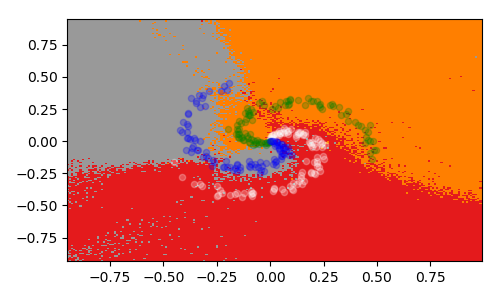

In [8]:
predictive = pyro.infer.Predictive(model, 
                                   guide=guide, 
                                   num_samples=1)

samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))

fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)

# print(samples["obs"]).size

zz = samples["obs"].reshape(xx.shape).detach().numpy()
# zz = samples["obs"].detach().numpy()
ax.pcolormesh(xx, yy, zz, cmap=plt.cm.Set1)

for i, m in enumerate(["w", "g", "b"]):
    ax.scatter(X[y==i, 0], X[y==i, 1], c=m, s=20, alpha=0.25)

As it can see, the NN can clasify the differents classes, but in the borders are very confused and not clear what class is each one.

In the red one class, there is a miss classification between red and gray class, and it can be because of various reasons, maybe the archiquecture, the epochs. So in order to improve, it can try differents architechtures or number of epochs.

I trained the NN using different number of ecpoch, and the more epoch it trained, the more capable the NN can classify differents classes. 

The training can be improved adding training / validation / testing data split. So while it is training with training data, it can be evaluating the validation error, so it can stop the training before overfitting.

## Compare with the  𝛼  divergence objective, explore the influence of  𝛼  in the results

In this trainig, It keeps the same parameters (and NN model), only changing the loss function.

In [19]:
# Define model
pyro.enable_validation(True)
pyro.clear_param_store()
model = leo_bayesian(num_hidden = 10, prior_std = 1.)

# define guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model, init_scale=1e-1)

# define SVI (model for training)
svi = pyro.infer.SVI(model,
                    guide,
                    optim=pyro.optim.ClippedAdam({'lr':1e-2}),
                    
                    # using alpha divergence
                    loss=pyro.infer.RenyiELBO()
                    )

n_epochs = 3000

# Training
epoch_loss = np.zeros(shape=(n_epochs,))

for epoch in tqdm(range(len(epoch_loss))):
    
    #print(epoch)
    
    epoch_loss[epoch] = svi.step(x_train, y_train)

## Visualizing results in data space

<IPython.core.display.Javascript object>


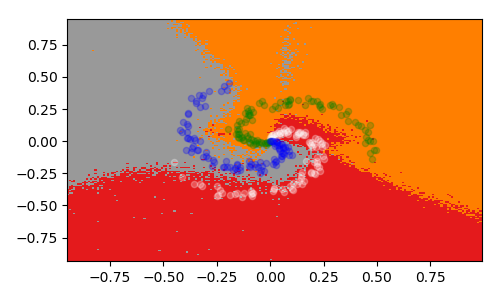

In [20]:
predictive = pyro.infer.Predictive(model, 
                                   guide=guide, 
                                   num_samples=1)

samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))

fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)

# print(samples["obs"]).size

zz = samples["obs"].reshape(xx.shape).detach().numpy()
# zz = samples["obs"].detach().numpy()
ax.pcolormesh(xx, yy, zz, cmap=plt.cm.Set1)

for i, m in enumerate(["w", "g", "b"]):
    ax.scatter(X[y==i, 0], X[y==i, 1], c=m, s=20, alpha=0.25)

This model was trained with more epoch than before one, and this is also getting an area with "bad classifications", and this is the orange one (this has gray classes). This can be because of architecture, the epochs, the parameters.

From the graphic, it can see that the model can classify the classes correctly, and maybe there is a little of overfitting.

The differences (for this case) of using conventional ELBO and alpha divergence is not clear, because both methods get similar results. Regarding to training time, they were very similar, maybe because it was not too much data and epochs.

## Compare with the SVGD estimator with RBF kernel, explore the influence of the kernel parameters

It defines the model again, because it needs others parameters and it is in next line:

- with pyro.plate("data",size = x.shape[0], dim = -2):

In [31]:
from pyro.nn import PyroSample, PyroModule
from pyro.distributions import Normal, Categorical

class leo_bayesian(PyroModule):
    
    def __init__(self, num_hidden = 10, prior_std = 1.):
        
        # call to father constructor
        super().__init__()
        
        # define prior
        prior = Normal(0, prior_std)
        
        # Define layers
        
        # linear layer 1
        self.linear_layer = PyroModule[torch.nn.Linear](2, num_hidden)
        
        # linear alyer parameters as random variables
        self.linear_layer.weights = PyroSample(prior.expand([num_hidden, 2]).to_event(2))
        self.linear_layer.bias = PyroSample(prior.expand([num_hidden]).to_event(1))
        
        # linear layer 2
        # output dimension is 3 because of the number of classes
        self.output_layer = PyroModule[torch.nn.Linear](num_hidden, 3)
        
        # linear alyer parameters as random variables
        self.output_layer.weights = PyroSample(prior.expand([3, num_hidden]).to_event(2))
        self.output_layer.bias = PyroSample(prior.expand([3]).to_event(1))
        
        # activation function
        self.activation = torch.nn.Tanh()
        
    def forward(self, x, y = None):
            
        # latent variable
        z = self.activation(self.linear_layer(x))
        
        z = self.output_layer(z).squeeze(1)
        
        # likelihood
        with pyro.plate("data",size = x.shape[0], dim = -2):
#         with pyro.plate("data",size = x.shape[0], dim = -2):
            
            # z is the input to the distribution (categorical)
            obs = pyro.sample("obs", Categorical(logits = z), obs=y)
            
        # return latent variable
        return z

In order to implement the SVGD algorithm, It needs to use the SVGD function, passing a specific kernel for that.

In [41]:
from pyro.infer import SVGD, RBFSteinKernel
from pyro.optim import Adam

# Define model
pyro.enable_validation(True)
pyro.clear_param_store()
model = leo_bayesian(num_hidden = 10, prior_std = 1.)

# kernel
kernel = RBFSteinKernel()
adam = Adam({"lr": 0.1})

# SVGD algotithm
svgd = SVGD(model, kernel, adam, num_particles=300, max_plate_nesting=0)

n_epochs = 1000

# for step in tqdm(range(len(epoch_loss))):
for step in tqdm(range(n_epochs)):
    svgd.step(x_train, y_train)

final_particles = svgd.get_named_particles()

## Display predictions on data space

In [42]:
# plotting resutls
predictive = pyro.infer.Predictive(model, 
#                                    guide=final_particles, 
                                   num_samples=1)

samples = predictive(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()].astype('float32')))

fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)

zz = samples["obs"].reshape(xx.shape).detach().numpy()
ax.pcolormesh(xx, yy, zz, cmap=plt.cm.Set1)

for i, m in enumerate(["w", "g", "b"]):
    ax.scatter(X[y==i, 0], X[y==i, 1], c=m, s=20, alpha=0.25)

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 16472430000 bytes. Error code 12 (Cannot allocate memory)

         Trace Shapes:            
          Param Sites:            
   linear_layer.weight    10  2   
   output_layer.weight     3 10   
         Sample Sites:            
linear_layer.bias dist        | 10
                 value        | 10
output_layer.bias dist        |  3
                 value        |  3
             data dist        |   
                 value 37050  |   

It could not to get the predictions using SVGD (I did not find the way to do it, and I did not find tutorials to do it, maybe it's because it i really new).

## Conclusions
It could to:

- Train a NN for the given dataset
- Train a NN using conventional ElBO
- Train NN using alpha divergence
- Compare conventional ELBO with alpha
- Train a NN using SVGD algorightm

Based on obtained results, there is no clear difference between training and results the NN using conventional ELBO and alpha divergence, and this is because the obtained results were similar.

I could not get predictions using SVGD, so I could not compare the 2 differents methods.